In [1]:
class gaussian_noise(object): 
    def __call__(self, image):
        return image + torch.randn_like(image) * 0.3


    def __repr__(self):
        return self.__class__.__name__+'()'

In [2]:
import torch
import numpy as np

In [46]:
from PIL import Image
from numpy import asarray
# load the image
image = Image.open('Image_10.jpg')
# convert image to numpy array
data = asarray(image)

In [47]:
import matplotlib.pyplot as plt

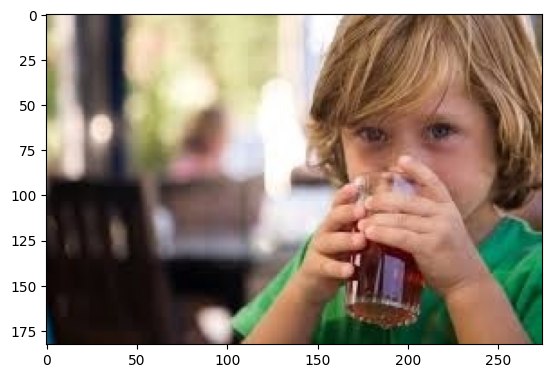

In [48]:
plt.imshow(data)

In [49]:
data = data.astype(np.float32) / 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


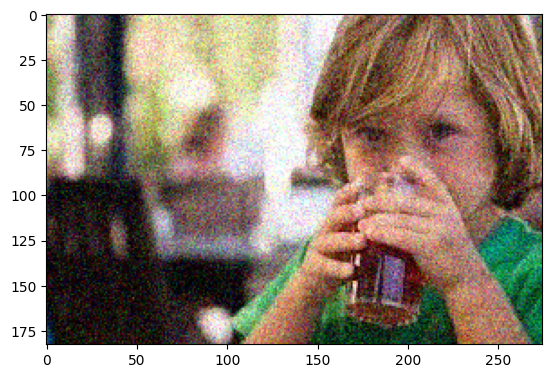

In [50]:
plt.imshow(torch.tensor(data) + torch.randn_like(torch.tensor(data)) * 0.1)

In [66]:
from model import CNN

In [67]:
net = CNN()
path = "models/bs256_lr0.0001_epoch29"

In [68]:
net.load_state_dict(torch.load(path))
net.eval()

CNN(
  (alexnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (f

In [74]:
from preprocessing import data_loader
from model import CNN
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def evaluation(net, batch_size=1024):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(0)

    if torch.cuda.is_available():
        print("yessir")
        net = net.to('cuda')

    train_loader, val_loader = data_loader(batch_size=batch_size)
    
    # cross entropy loss function
    criterion = nn.CrossEntropyLoss()

    # softmax for predictions
    softmax = nn.Softmax(dim = 1)
    
    # initialize error and loss history
    total_train_loss = 0.0
    total_train_err = 0.0
    train_iters = 0

    total_val_loss = 0.0
    total_val_err = 0.0
    val_iters = 0

    train_batches = 0
    net.eval()
    for batch in tqdm(train_loader):
        train_batches += 1
        imgs, labels = batch.values()
        if torch.cuda.is_available():
            imgs = imgs.to('cuda')
            labels = labels.to('cuda')
        outputs = net(imgs)
        loss = criterion(outputs, labels)

        pred = softmax(outputs)
        # find error and loss for training data
        total_train_err += (np.argmax(pred.detach().cpu(), 1) != np.argmax(labels.cpu(), 1)).sum().item()
        print(total_train_err)
        total_train_loss += loss.item()
        train_iters += len(labels)

    val_batches = 0
    for batch in tqdm(val_loader):
        val_batches += 1
        imgs, labels = batch.values()
        if torch.cuda.is_available():
            imgs = imgs.to('cuda')
            labels = labels.to('cuda')
        outputs = net(imgs)
        loss = criterion(outputs, labels)

        pred = softmax(outputs)

        # find error and loss for training data
        total_val_err += (np.argmax(pred.detach().cpu(), 1) != np.argmax(labels.cpu(), 1)).sum().item()
        total_val_loss += loss.item()
        val_iters += len(labels)

    return total_train_loss, total_train_err, total_val_loss, total_val_err

In [75]:
result = evaluation(net)

yessir


  1%|▏         | 1/69 [00:03<03:48,  3.36s/it]

325.0


  3%|▎         | 2/69 [00:06<03:44,  3.34s/it]

681.0


  4%|▍         | 3/69 [00:10<03:44,  3.41s/it]

1031.0


  6%|▌         | 4/69 [00:13<03:45,  3.47s/it]

1357.0


  7%|▋         | 5/69 [00:17<03:37,  3.40s/it]

1695.0


  9%|▊         | 6/69 [00:20<03:37,  3.45s/it]

2035.0


 10%|█         | 7/69 [00:23<03:32,  3.43s/it]

2380.0


 12%|█▏        | 8/69 [00:27<03:28,  3.42s/it]

2722.0


 12%|█▏        | 8/69 [00:29<03:42,  3.65s/it]


KeyboardInterrupt: 

In [71]:
print(result)

(77.24087035655975, 23370.0, 4.018924951553345, 1040.0)


In [80]:
train_loader, val_loader = data_loader(batch_size=1)

In [81]:
print(1-23370.0/len(train_loader), 1-1040.0/len(val_loader))

0.6687925170068028 0.5873015873015873


In [1]:
# Our model
import torch.nn as nn
import torchvision.models

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Transfer learning from alexnet
        self.fc1 = nn.Linear(256*6*6, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 15)

    def forward(self, x):
        x = self.dropout(x).detach()
        x = x.view(-1, 256*6*6)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        return self.fc3(x)

In [2]:
from preprocessing import data_loader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def train(net, batch_size=32, lr=0.001, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(0)

    if torch.cuda.is_available():
        net = net.cuda()

    train_loader, val_loader = data_loader(batch_size=batch_size)
    
    # cross entropy loss function and adaptive moment estimation optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(net.parameters(), lr = lr, weight_decay=0.1)

    # softmax for predictions
    softmax = nn.Softmax(dim = 1)
    
    # initialize error and loss history
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0.0
        total_train_err = 0.0
        train_iters = 0

        total_val_loss = 0.0
        total_val_err = 0.0
        val_iters = 0
        
        train_batches = 0
        net.train()
        for batch in train_loader:
            train_batches += 1
            imgs, labels = batch.values()
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            pred = softmax(outputs)
            # find error and loss for training data
            total_train_err += (np.argmax(pred.detach().cpu(), 1) != np.argmax(labels.cpu(), 1)).sum().item()
            total_train_loss += loss.item()
            train_iters += len(labels)

        val_batches = 0
        net.eval()
        for batch in val_loader:
            val_batches += 1
            imgs, labels = batch.values()
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            outputs = net(imgs)
            loss = criterion(outputs, labels)

            pred = softmax(outputs)

            # find error and loss for training data
            total_val_err += (np.argmax(pred.detach().cpu(), 1) != np.argmax(labels.cpu(), 1)).sum().item()
            total_val_loss += loss.item()
            val_iters += len(labels)

        # record the average error (per iteration) and loss (per batch) for each epoch
        train_err[epoch] = total_train_err / train_iters
        train_loss[epoch] = total_train_loss / train_batches
        val_err[epoch] = total_val_err / val_iters
        val_loss[epoch] = total_val_loss / val_batches
        print(f"Epoch {epoch}: Train err: {train_err[epoch]} Val err: {val_err[epoch]} Train loss: {train_loss[epoch]} Val loss: {val_loss[epoch]}")
        # save model
        model_path = "/models/bs{}_lr{}_epoch{}".format(batch_size,
                                              lr,
                                              epoch)
        torch.save(net.state_dict(), model_path)
    return train_err, train_loss, val_err, val_loss

def plot(train_err, train_loss, val_err, val_loss):
    n = len(train_err) # number of epochs

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("Train vs Validation Error")
    ax1.plot(range(1,n+1), train_err, label="Train")
    ax1.plot(range(1,n+1), val_err, label="Validation")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Error")
    ax1.legend(loc='best')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_title("Train vs Validation Loss")
    ax2.plot(range(1,n+1), train_loss, label="Train")
    ax2.plot(range(1,n+1), val_loss, label="Validation")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc='best')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    plt.show()

def performance_per_class(net):
    net.eval()
    _, val_loader = data_loader(batch_size=1)
    errors = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0,
        10:0,
        11:0,
        12:0,
        13:0,
        14:0,
    }
    total = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0,
        10:0,
        11:0,
        12:0,
        13:0,
        14:0,
    }
    wrong_guesses = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0,
        10:0,
        11:0,
        12:0,
        13:0,
        14:0,
    }
    guesses = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0,
        10:0,
        11:0,
        12:0,
        13:0,
        14:0,
    }
    softmax = nn.Softmax(dim = 1)
    for batch in val_loader:
        img, label = batch.values()
        output = softmax(net(img))
        pred = np.argmax(output.detach()).item()
        truth = np.argmax(label).item()
        if pred != truth:
            errors[truth] += 1
            wrong_guesses[pred] += 1
        total[truth] += 1
        guesses[pred] += 1
    for i in range(15):
        wrong_guesses[i] /= guesses[i]
        errors[i] /= total[i]
    return errors, wrong_guesses, guesses

C:\Users\caixu\anaconda3\envs\consens\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\caixu\anaconda3\envs\consens\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# net = Baseline()
# train_err, train_loss, val_err, val_loss = train(net, 64, 0.001, 20)
# plot(train_err, train_loss, val_err, val_loss)
net = CNN()
#net.load_state_dict(torch.load("./models/bs256_lr0.0001_epoch29", map_location=torch.device('cpu')))
#print(net)
train_err, train_loss, val_err, val_loss = train(net, 256, 0.0001, 29)

  0%|          | 0/29 [01:36<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
error_rate, wrong_guess_rate, guesses = performance_per_class(net)
# print("The error rate is:"+ str(error_rate))
# print(wrong_guess_rate)
# print(guesses)
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
xtick = ["sitting", "using_laptop", "hugging", "sleeping", "drinking", "clapping", "dancing", "cycling",
 "calling", "laughing", "eating", "fighting", "listening_to_music", "running", "texting"]

plt.xticks(x, xtick, rotation=45)
plt.plot(x, error_rate.values())
plt.title("Error rates per class")
plt.xlabel("Class")
plt.ylabel("Error rate")
plt.show()
plt.xticks(x, xtick, rotation=45)
plt.plot(x, wrong_guess_rate.values())
plt.title("Wrong guess rate per class")
plt.xlabel("Class")
plt.ylabel("Wrong guess rate")
plt.show()
plt.xticks(x, xtick, rotation=45)
plt.plot(x, guesses.values())
plt.title("Guesses per class")
plt.xlabel("Class")
plt.ylabel("Number of guesses")
plt.show()

In [8]:
import numpy as np
def new_dataset(batch_size=1, dire = "alex_embedding"):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(0)

    train_loader, val_loader = data_loader(batch_size=batch_size, shuffle=False)
    id=1
    for batch in tqdm(train_loader):
        imgs, labels = batch.values()
        labels = torch.argmax(labels, dim=1)
        np.save(f"{dire}/train/embed_{id}", imgs.numpy())
        np.save(f"{dire}/train/label_{id}", imgs.numpy())
        id += 1
        
    id=1
    for batch in tqdm(val_loader):
        imgs, labels = batch.values()
        labels = torch.argmax(labels, dim=1)
        np.save(f"{dire}/test/embed_{id}", imgs.numpy())
        np.save(f"{dire}/test/label_{id}", imgs.numpy())
        id += 1

In [9]:
new_dataset()

  2%|▏         | 1089/70560 [00:09<10:08, 114.12it/s]


KeyboardInterrupt: 